# Exercises Week 4 in 02506

This weeks exercises are concerned with feature based registration and SIFT from OpenCV.
<p align="center"> 
  <img src="images/ct_lab_high_res.PNG" width="300" title="Artificially generated blobs">
</p>

## Imports

In [1]:
import numpy as np
from skimage.io import imread, imshow, imsave
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from skimage import color
import cv2

## 4.1 Exercise on feature-based registration

### 1. Generate a random 2D point set P.

In [327]:
H = 256
W = 408
np.random.seed(199)
P = np.zeros([H,W]).astype(float)
tmp = np.random.rand(80,60)
tmp[tmp<0.97]=0
tmp[tmp>=0.97]=255
P[68:148,164:224] = tmp


### 2. Define variables for translation t, rotation R, and scale s, and decide on their values.

### 3. Transform P using these parameters to obtain the point set Q.

In [328]:
def RotateScaleTranslate(img,theta,t=[[0],[0]],s=1.0):
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    H,W = np.shape(img)
    cx = H/2
    cy = W/2
    print(f"H={H},W={W}")
    new_img = np.zeros([H,W])
    for x in range(0,H):
        for y in range(0,W):
            xybar = s*(R@[[x-cx],[y-cy]])+t
            xbar = np.round(cx+xybar[0]).astype(int)
            ybar = np.round(cy+xybar[1]).astype(int)
            if (xbar >= 0) and (xbar < H) and (ybar >= 0) and  (ybar < W):
                #print(f"x={x},y={y}")
                new_img[xbar,ybar] = img[x,y]
    return new_img, R

Q,R = RotateScaleTranslate(P,0.5,t=[[30],[-60]],s=2.2)
print(f"R is {R} ")

H=256,W=408
R is [[ 0.87758256 -0.47942554]
 [ 0.47942554  0.87758256]] 


### 4. Plot these point sets using two different colors.

(0.0, 408.0)

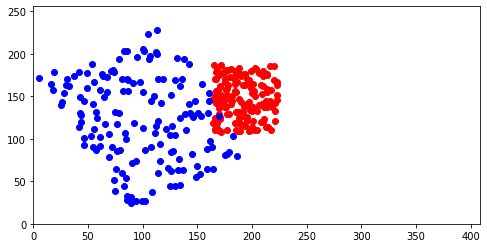

In [329]:
def getPointsPlot(arr):
    nonz = np.nonzero(arr)
    x = nonz[1]
    y = H-1-nonz[0]
    return x,y

Px, Py = getPointsPlot(P)
Qx, Qy = getPointsPlot(Q)

fig, (ax1) = plt.subplots(1, 1,figsize=(8,4))
ax1.scatter(Px, Py, color='Red')
ax1.scatter(Qx, Qy, color='Blue')
ax1.set_ylim([0,H])
ax1.set_xlim([0,W])

### 5. Implement a function that computes the parameters t', rotation R', and scale s' from P and Q. Make sure that you get the exact same values.

In [330]:
def getCoords(arr):
    nonz = np.nonzero(arr)
    x = nonz[0].astype(float)
    y = nonz[1].astype(float)
    return x,y

def getCenter(x,y):
    return np.array([[np.mean(x)],[np.mean(y)]])

def getScale(P,Q):
    Px,Py = getCoords(P)
    Pmu = getCenter(Px,Py)
    Qx,Qy = getCoords(Q)
    Qmu = getCenter(Qx,Qy)
    sumP = np.sum([np.sqrt((x-Pmu[0])**2 + (y-Pmu[1])**2) for x,y in zip(Px,Py)])
    sumQ = np.sum([np.sqrt((x-Qmu[0])**2 + (y-Qmu[1])**2) for x,y in zip(Qx,Qy)])
    return sumQ/sumP

def getRot(P,Q):
    cx = H/2
    cy = W/2
    Px,Py = getCoords(P)
    Px = Px-cx
    Py = Py-cy
    Pmu = getCenter(Px,Py)
    tmp1 = np.array([Px,Py])-Pmu
    Qx,Qy = getCoords(Q)
    Qx = Qx-cx
    Qy = Qy-cy
    Qmu = getCenter(Qx,Qy)
    tmp2 = np.array([Qx,Qy])-Qmu
    C = sum([np.array([[q[0]*p[0],q[0]*p[1]],[q[1]*p[0],q[1]*p[1]]]) for q,p in zip(tmp1.T,tmp2.T)])
    #[print(np.array(q)@np.array(p).T) for q,p in zip(tmp1.T,tmp2.T)]
    U,_,Vt = np.linalg.svd(C,full_matrices=True)
    Rbar = np.matmul(U,Vt)
    Rbar = np.matmul(Rbar,[[1.0,0.0],[0.0,np.linalg.det(Rbar)]])
    return Rbar

def getTranslation(P,Q,R,s):
    cx = H/2
    cy = W/2
    Px,Py = getCoords(P)
    Px = Px-cx
    Py = Py-cy
    Pmu = getCenter(Px,Py)
    Qx,Qy = getCoords(Q)
    Qx = Qx-cx
    Qy = Qy-cy
    Qmu = getCenter(Qx,Qy)
    return Qmu-s*R@Pmu

sbar = getScale(P,Q)
Rbar = getRot(P,Q)
tbar = getTranslation(P,Q,Rbar,sbar)
print(f"s={sbar}")
print(f"t={tbar}")
print(f"R={Rbar}")

s=2.2011532464739014
t=[[ 41.86310018]
 [-69.06451889]]
R=[[ 0.97669665 -0.21462444]
 [ 0.21462444  0.97669665]]


### 6. Add some noise to Q and recompute the parameters and test how much noise you can add and still get reasonably good parameter estimates.

s=2.2011532464739014
t=[[ 41.86310018]
 [-69.06451889]]
R=[[ 0.97669665 -0.21462444]
 [ 0.21462444  0.97669665]]


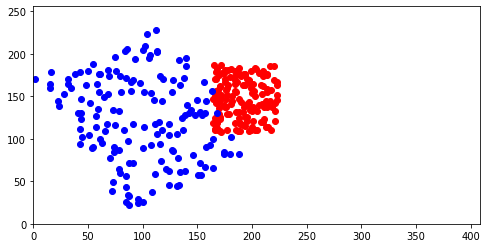

In [331]:
Qnoisy = Q.copy()
Qx,Qy = getCoords(Q)
for i in range(np.size(Qx)):
    x = Qx[i].astype(int)
    y = Qy[i].astype(int)
    d = -3 + np.random.randint(6,size=2)
    Qnoisy[[x],[y]] = 0
    Qnoisy[[x+d[0]],[y+d[1]]] = Q[x,y]

Px, Py = getPointsPlot(P)
Qx, Qy = getPointsPlot(Qnoisy)
fig, (ax1) = plt.subplots(1, 1,figsize=(8,4))
ax1.scatter(Px, Py, color='Red')
ax1.scatter(Qx, Qy, color='Blue')
ax1.set_ylim([0,H])
ax1.set_xlim([0,W])

#sbar = getScale(P,Qnoisy)
#Rbar = getRot(P,Qnoisy)
#tbar = getTranslation(P,Qnoisy,Rbar,sbar)

print(f"s={sbar}")
print(f"t={tbar}")
print(f"R={Rbar}")

## 4.1.2 Compute and match SIFT
### 1. Create a transformed image by rotating, scaling, and cropping an image. We call the original image1 and the transformed image2.

H=400,W=400


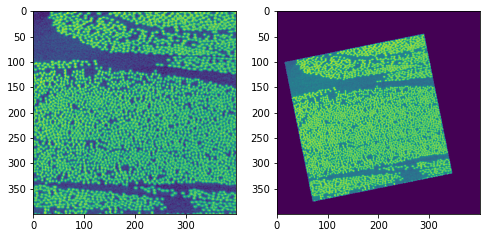

In [332]:
img1 = imread("./images/CT_lab_low_res.png")
img2,R2 = RotateScaleTranslate(img1,0.2,t=[[10],[-20]],s=0.7)
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
ax1.imshow(img1)
ax2.imshow(img2)

### 2. Compute SIFT features in the two images.

Lossy conversion from float64 to uint8. Range [0.0, 48212.0]. Convert image to uint8 prior to saving to suppress this warning.


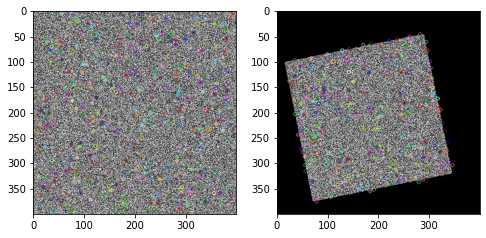

In [333]:
def np2cv(P):
    return ((P - np.min(P)) * 255 / np.max(P)).astype(np.uint8)

def npSift(P):
    data = np2cv(P)
    gray = data.astype(np.uint8)
    sift = cv2.SIFT_create()
    kp = sift.detect(gray,None)
    img=cv2.drawKeypoints(gray,kp,P)
    return img

def sift(img1):
    gray = img1.astype(np.uint8)
    sift1 = cv2.SIFT_create()
    kp = sift1.detect(gray,None)
    img=cv2.drawKeypoints(gray,kp,img1)
    return img

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
ax1.imshow(sift(img1))
ax2.imshow(sift(img2))

imsave('./images/test_img.png',img1)
imsave('./images/test_img_transformed.png',img2)

### 3. Match the SIFT features. You can use the functionality for matching SIFT from vlFeat for MATLAB and OpenCV for Python.
### 4. Display the match to see if the matching criterion is correct.

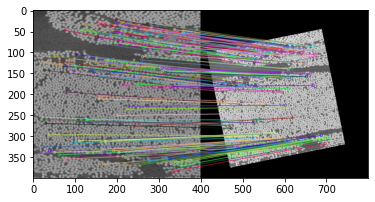

(<matplotlib.image.AxesImage at 0x7f36ccf35e50>, None)

In [334]:
img1 = cv2.imread('./images/test_img.png',cv2.IMREAD_GRAYSCALE)          # queryImage
img2 = cv2.imread('./images/test_img_transformed.png',cv2.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance/(n.distance+1e-10) < 0.25:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### 5. Extract the coordinates of the matching keypoints.

In [335]:
pts1 = []
pts2 = []
for m,n in matches:
    if m.distance/(n.distance+1e-10) < 0.60:
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

### 6. Use the function for computing the rotation, translation, and scale from before to transform the set of key points found in image1 to the set of keypoints found in image2.

### 7. Display image2 and plot the key points found in image2 and the transformed key points from image1.

Estimated homography : 
 [[ 1.40074909e+00 -2.83731681e-01  7.68083113e+00]
 [ 2.84123945e-01  1.40074181e+00 -1.45145504e+02]
 [ 7.62711328e-07  9.21737549e-07  1.00000000e+00]]


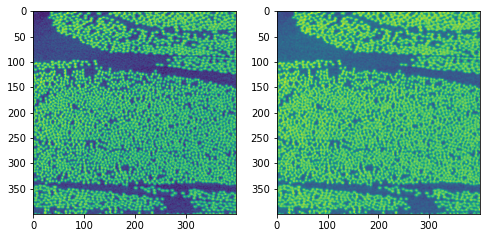

In [344]:
pts1 = []
pts2 = []
num_matches = 0
for m,n in matches:
    if m.distance/(n.distance+1e-10) < 0.60:
        pts2.append([kp1[m.queryIdx].pt[0],kp1[m.queryIdx].pt[1]])
        pts1.append([kp2[m.trainIdx].pt[0],kp2[m.trainIdx].pt[1]])
        num_matches = num_matches+1
pts1 = np.reshape(pts1,[num_matches,2,1])
pts2 = np.reshape(pts2,[num_matches,2,1])

h, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC)

height, width = img2.shape
im1Reg = cv2.warpPerspective(img2, h, (width, height))

print("Estimated homography : \n",  h)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8,4))
ax1.imshow(img1)
ax2.imshow(im1Reg)

### Quiz